# CogPonder: Stroop task with fixed hyper-parameters

This notebook implements the CogPonder framework using PyTorch Lightning and evaluate it on the Stroop task.


It assumes fixed hyper-parameters and fits the model to a single-subject dataset. It wraps a simple linear network with a pondering layer and trains it on the *Self-Regulation Ontology* dataset.


## Data

Here, we fit the Stroop data from the *Self-Regulation Ontology*. The data is loaded from the `data/Self_Regulation_ontology/` directory; see the [README](../data/Self_Regulation_Ontology/README.md) for more information on the data structure.

### Input and Output


The input contains a list of trials, each includes 1) the color and 2) the letter of the current stimulus. The output is the human response to the current trial (i.e., red, green, or blue).


## Hyper-parameters

- `n_embeddings`: number of hidden units in the operator model. Defaults to 2.
- `resp_loss_beta`: the beta parameter of the loss function. Defaults to 1.
- `time_loss_beta`: the beta parameter of the loss function. Defaults to 0.5.
- `learning_rate`: the learning rate of the optimizer. Defaults to 0.0001.
- `max_response_step`: maximum response step in the dataset. Defaults to 100.

## Criterion

The loss function is a weighted sum of the response loss regularized by the response time loss. The regularizer weight is controlled by the `time_loss_beta` hyper-parameter.

$L = L_{\text{response}} + \beta L_{\text{time}}$


In [14]:
%reload_ext autoreload
%autoreload 3

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

import torch
import torchmetrics
import pytorch_lightning as pl
import pandas as pd
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks.progress.rich_progress import RichProgressBar
from src.cogponder import CogPonderModel
from src.cogponder.datasets import StroopSRODataset, CogPonderDataModule
from pathlib import Path

In [15]:
# this notebook only fits one SRO subject, which its SRO-SubjectID can be defined here
SRO_SUBJECT_ID = 202

# number of maximum epochs to train
MAX_EPOCHS = 10000

# upon successful training, the model will be saved to this path
CHECKPOINT_PATH = Path('models/stroop/') / f'cogponder_subject-{SRO_SUBJECT_ID}_epochs-{MAX_EPOCHS}.ckpt'

In [95]:
# Load the dataset and configs

print('Loading Stroop dataset... ', end='')

dataset = StroopSRODataset(n_subjects=-1, response_step_interval=10, non_decision_time='auto')
data = dataset[SRO_SUBJECT_ID]

# determine the number of loaded subjects
n_subjects = data[:][0].size(1)

# parameter space
CONFIG = {
    'task': 'stroop',
    'resp_loss_beta': 1.,
    'time_loss_beta': 10.,
    # 'non_decision_time': 10,  # in milliseconds
    'loss_by_trial_type': False,
    'learning_rate': 1e-2,
    'max_response_step': data[4].max().int().item() + 10,
    'inputs_dim': data[0].size(1) - 1,  # minus subject_id (first column)
    'embeddings_dim': 2,
    'outputs_dim': torch.unique(data[3]).size(0),  # number of unique responses
    'auto_lr_find': False,
    'batch_size': 72,
    'n_subjects': 1
}

datamodule = CogPonderDataModule(data,
                                 batch_size=CONFIG['batch_size'],
                                 num_workers=8)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Done!')

Loading Stroop dataset... Done!


In [ ]:
# Define the pondering model and run the trainer

model = CogPonderModel(CONFIG)#, example_input_array=data[0][:1].to(device))

# Trainer
trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    # min_epochs=100,
    accelerator='auto',
    auto_lr_find=CONFIG['auto_lr_find'],
    log_every_n_steps=1,
    # overfit_batches=True,
    # accumulate_grad_batches=2,
    callbacks=[
        RichProgressBar(),
        EarlyStopping(monitor='val/total_loss',
                      patience=np.max([10, MAX_EPOCHS // 10]).item(),
                      mode='min', min_delta=0.001),
    ])

# Auto-detect learning-rate if the flag is set
if CONFIG['auto_lr_find']:
    trainer.tune(model, datamodule=datamodule)

# Fit and evaluate the model
trainer.fit(model, datamodule=datamodule)

# Save the latest checkpoint
trainer.save_checkpoint(CHECKPOINT_PATH)

In [94]:
# DEBUG

# DEBUG - Load the checkpoint

model_ckpt = CogPonderModel.load_from_checkpoint(CHECKPOINT_PATH)
model_ckpt.eval()

if not 'datamodule' in locals() or not hasattr(datamodule, 'train_dataset'):
    print('loading data module...', end='')
    data = StroopSRODataset(n_subjects=-1, response_step_interval=10)[SRO_SUBJECT_ID]
    datamodule = CogPonderDataModule(data, batch_size=CONFIG['batch_size'], num_workers=8)
    datamodule.prepare_data()
    print('Done!')

X_train, trial_types_train, is_corrects_train, y_train, rt_train = datamodule.train_dataset[:]
X_test, trial_types_test, is_corrects_test, y_test, rt_test = datamodule.test_dataset[:]

with torch.no_grad():
    model_ckpt.eval()

    y_train_steps,p_train,rt_train_pred = model_ckpt(X_train)
    y_test_steps,p_test,rt_test_pred = model_ckpt(X_test)

    y_train_steps = torch.argmax(y_train_steps, dim=-1)
    y_test_steps = torch.argmax(y_test_steps, dim=-1)

    y_train_pred = y_train_steps.gather(dim=0, index=rt_train_pred[None, :] - 1,)[0]  # (batch_size,)
    y_test_pred = y_test_steps.gather(dim=0, index=rt_test_pred[None, :] - 1,)[0]  # (batch_size,)

    train_res = pd.DataFrame({'true_rt_train': rt_train.detach().tolist(),
                              'pred_rt_train': rt_train_pred.tolist()})
    test_res = pd.DataFrame({'true_rt_test': rt_test.detach().tolist(),
                             'pred_rt_test': rt_test_pred.tolist()})

    display(train_res.T, test_res.T)

    # report Stroop accuracy
    is_corrects_pred = (y_test_pred.long() == y_test).float()
    cong_is_corrects = torch.where(trial_types_test == 1, is_corrects_pred, torch.nan)
    incong_is_corrects = torch.where(trial_types_test == 0, is_corrects_pred, torch.nan)

    accuracy = torch.nanmean(is_corrects_pred)
    cong_accuracy = torch.nanmean(cong_is_corrects)
    incong_accuracy = torch.nanmean(incong_is_corrects)

    print('Stroop %correct (total / congruent / incongruent): {:.3f} / {:.3f} / {:.3f}'.format(
            accuracy.item(), cong_accuracy.item(), incong_accuracy.item()))

# DEBUG report mean-RT
print(f'RT train mean (pred/true): '
      f'{rt_train_pred.float().mean().item():.2f}, '
      f'{rt_train.float().mean().item():.2f}')

print(f'RT test  mean (pred/true): '
      f'{rt_test_pred.float().mean().item():.2f}, '
      f'{rt_test.float().mean().item():.2f}')

# DEBUG - report sd-RT
print(f'RT train std (pred/true): '
      f'{rt_train_pred.float().std().item():.2f}, '
      f'{rt_train.float().std().item():.2f}')

print(f'RT test  std (pred/true): '
      f'{rt_test_pred.float().std().item():.2f}, '
      f'{rt_test.float().std().item():.2f}')



,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
true_rt_train,18,14,38,15,17,41,62,35,14,15,...,42,76,24,92,37,48,15,4,13,4
pred_rt_train,33,36,49,36,34,62,74,5,29,29,...,20,23,81,92,31,39,13,20,65,15


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
true_rt_test,14,63,8,1,58,54,68,17,27,22,...,50,38,37,27,53,27,6,72,46,19
pred_rt_test,22,105,64,22,37,105,32,27,41,25,...,105,45,10,44,38,29,21,22,55,50


Stroop %correct (total / congruent / incongruent): 0.958 / 1.000 / 0.929
RT train mean (pred/true): 38.40, 39.17
RT test  mean (pred/true): 41.75, 34.54
RT train std (pred/true): 25.36, 24.20
RT test  std (pred/true): 28.62, 20.78


In [23]:
# prepare plotting data

plot_data_train = pd.DataFrame({
    'rt': rt_train,
    'trial_type': trial_types_train,
    'color': X_train[:, 0],
    'word': X_train[:, 1],
    'data': 'truth',
    'split': 'train',
})

plot_data_train_pred = pd.DataFrame({
    'rt': rt_train_pred,
    'trial_type': trial_types_train,
    'color': X_train[:, 0],
    'word': X_train[:, 1],
    'data': 'pred',
    'split': 'train',
})

plot_data_test = pd.DataFrame({
    'rt': rt_test,
    'trial_type': trial_types_test,
    'color': X_test[:, 0],
    'word': X_test[:, 1],
    'data': 'truth',
    'split': 'test',
})

plot_data_test_pred = pd.DataFrame({
    'rt': rt_test_pred,
    'trial_type': trial_types_test,
    'color': X_test[:, 0],
    'word': X_test[:, 1],
    'data': 'pred',
    'split': 'test',
})

# merge and cleanup
plot_data = pd.concat([plot_data_train, plot_data_train_pred, plot_data_test, plot_data_test_pred])
plot_data['trial_type'] = plot_data['trial_type'].map({0: 'incongruent', 1: 'congruent'})

max_rt = CONFIG["max_response_step"]

plot_data = plot_data.query('rt < @max_rt')

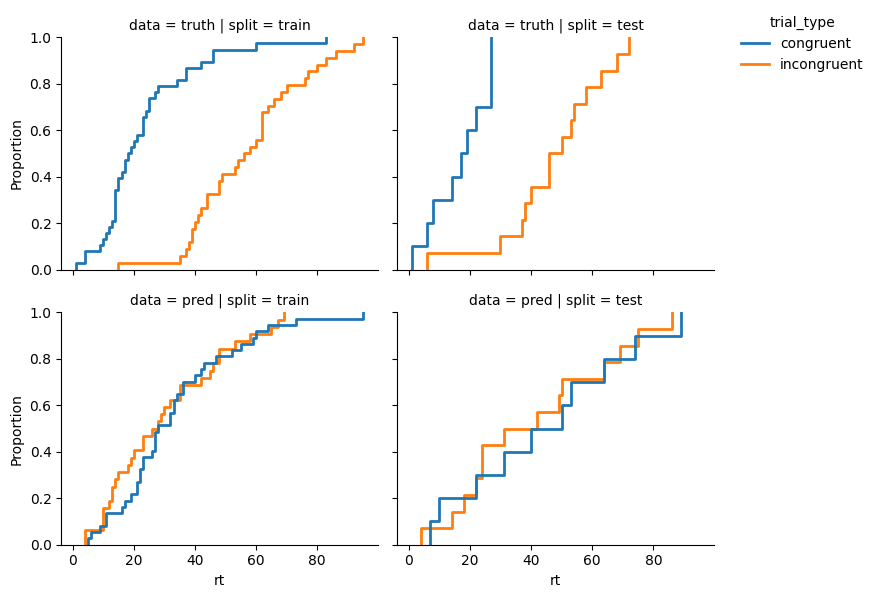

In [19]:

g = sns.displot(
    plot_data,
    x='rt', row='data', col='split', hue='trial_type',
    kind='ecdf', linewidth=2, height=3,
)

sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))


# plt.title(f'Evaluation profile of CogPonder on train split (Stroop)')

plt.tight_layout()
plt.show()


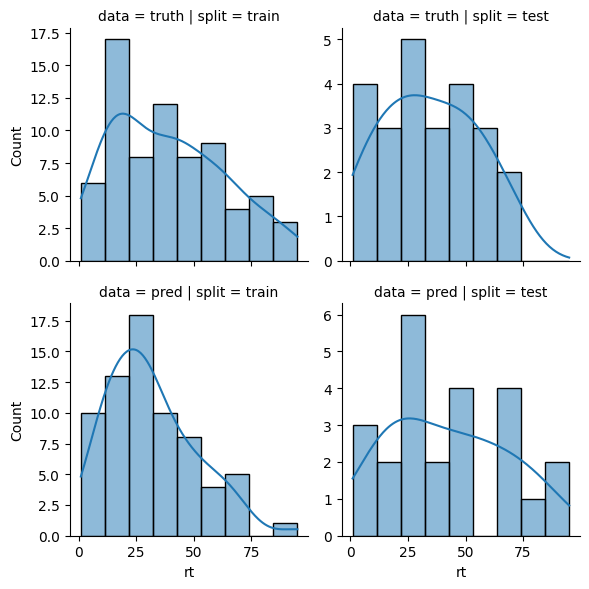

In [20]:
g = sns.displot(
    plot_data.reset_index(),
    x='rt', row='data', col='split', #hue='trial_type',
    kind='hist', height=3, #palette='Greens',
    kde=True, kde_kws={'clip': (0, max_rt)},
    facet_kws={'sharey': False}
)
# sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))


# plt.title(f'Evaluation profile of CogPonder on train split (Stroop)')

plt.tight_layout()
plt.show()
